In [0]:
### GPU version

#import packages

import numpy as np
import torch
import torch.cuda as cuda
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.datasets as datasets
from torchvision import transforms

In [0]:
# create a network

class convl(torch.nn.Module):
  def  __init__(self,input_channel,output_classes):
    super().__init__()
    
#     input:  torch.Size([batch_size, input_channel, 28, 28]) ->[batch_size, 1, 28, 28]

    #padding default= 0 , stride default= 1
    self.conv1=torch.nn.Conv2d(input_channel,20,kernel_size=3)# input_channel=1 , 20=number of filter
    self.relu1=torch.nn.ReLU() # size =  torch.Size([batch_size, 20, 26, 26])
    
    self.conv2=torch.nn.Conv2d(20,30,kernel_size=5) 
    self.relu2=torch.nn.ReLU()# size =  torch.Size([batch_size, 30, 22, 22])
    self.drop2=torch.nn.Dropout2d(p=0.5)# p = probability of being off
    self.maxPool2=torch.nn.MaxPool2d(2)# 2 = kernel_size | default stride here is kenrel size=2
    # size =  torch.Size([batch_size, 30, 11, 11])
    
    
    
    self.fc1=torch.nn.Linear(3630,500) # 30*11*11=3630
    self.fc2=torch.nn.Linear(500,output_classes)
    
    
  def forward(self,x):
    out=self.conv1(x)
    out=self.relu1(out)
    out=self.conv2(out)
    out=self.relu2(out)
    out=self.drop2(out)
    out=self.maxPool2(out) 
    
    out=out.view(-1,3630)
    #torch.Size([batch_size, 3630])

    out=self.fc1(out)
    out=torch.nn.functional.relu(out)
    out=self.fc2(out)
    #torch.Size([batch_size, 10])
    
    return out
  
 
    

In [41]:
model=convl(1,10)
print(model)


if cuda.is_available():
    model = model.cuda()
    
    
#print parameters size
print("\nParameters size: ")
for param in model.parameters():
  print(param.shape)

convl(
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(20, 30, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (drop2): Dropout2d(p=0.5)
  (maxPool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3630, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

Parameters size: 
torch.Size([20, 1, 3, 3])
torch.Size([20])
torch.Size([30, 20, 5, 5])
torch.Size([30])
torch.Size([500, 3630])
torch.Size([500])
torch.Size([10, 500])
torch.Size([10])


In [0]:
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=0.005)


Number of train samples:  60000
Number of test samples:  10000


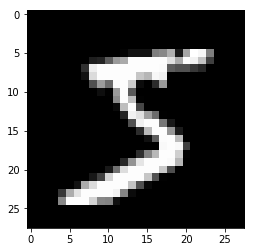

In [45]:
#dataset 

mytransform = transforms.Compose([
   
    transforms.ToTensor()
])
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=mytransform)
mnist_testset =  datasets.MNIST(root='./data', train=False, download=True, transform=mytransform)
print("Number of train samples: ",len(mnist_trainset))
print("Number of test samples: ",len(mnist_testset))
# first X in train set:  mnist_trainset[0][0] -> torch.Size([1, 28, 28])
# first y in train set:  mnist_trainset[0][1] -> int 5

#showing fist sample
plt.imshow(mnist_trainset[0][0].reshape(28,28).numpy(),cmap='gray')



train_loader = torch.utils.data.DataLoader(
                 dataset=mnist_trainset,
                 batch_size=20,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=mnist_testset,
                batch_size=20,
                shuffle=False)



In [0]:
# create batches:
def create_batches():
  train_loader = torch.utils.data.DataLoader(
                   dataset=mnist_trainset,
                   batch_size=20,
                   shuffle=True)
  test_loader = torch.utils.data.DataLoader(
                  dataset=mnist_testset,
                  batch_size=len(mnist_testset),
                  shuffle=False)# just 1 batch for testset
  return (train_loader,test_loader)
# bottom lines show how to access to the batches
# for batchNumber, (x, y) in enumerate(train_loader):
#   pass
############COMMENTS#########
###   batchNumber = number of batch ->  (int)
###   x -> torch.Size([batch_size,1,28,28)
###   y -> torch.Size([batch_size])

In [0]:
# calculating accuracy

def cal_accuracy(pred_classes,real_classes):#  shape -> both : [number of test samples,1]  or both : [number of test samples,]
  bool_array=(pred_classes==real_classes) # example: bool_array=[True, False, True, False, True]
  True_pred_counts=np.count_nonzero(bool_array) # count number of Trues in [True, False, True, False, True]
  
  return True_pred_counts/pred_classes.shape[0]

In [0]:
# Train and test

num_epochs=10
testacc=[]
for i in range(num_epochs):
  train_loader,test_loader=create_batches()
  for batchNumber, (x, y) in enumerate(train_loader):
    
    X=torch.autograd.Variable(torch.FloatTensor(x)) #x and X:torch.Size([batch_size, 1, 28, 28]) 
    Y=torch.autograd.Variable(torch.LongTensor(y))  #y and Y:torch.Size([batch_size]) 
    if cuda.is_available():
            X = X.cuda()
            Y = Y.cuda()
    model.train() 
    outputs=model(X)#output: torch.Size([batchsize, 10]) | 10 is number of output neurons
    loss=criterion(outputs,Y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

    
    
  ##test at end of each epoch
  for batchNumber, (x, y) in enumerate(test_loader):
    test_pred=model(torch.FloatTensor(x).cuda()) # x: torch.Size([10000, 1, 28, 28]) | test_pred : torch.Size([10000, 10])
    pred_classes=torch.max(test_pred.data, 1)[1]# torch.Size([10000])
    acc=cal_accuracy(np.array(pred_classes.cpu()),y.numpy()) #y: torch.Size([10000]) | y.numpy() -> (10000,)
    testacc.append(acc*100)
  
  


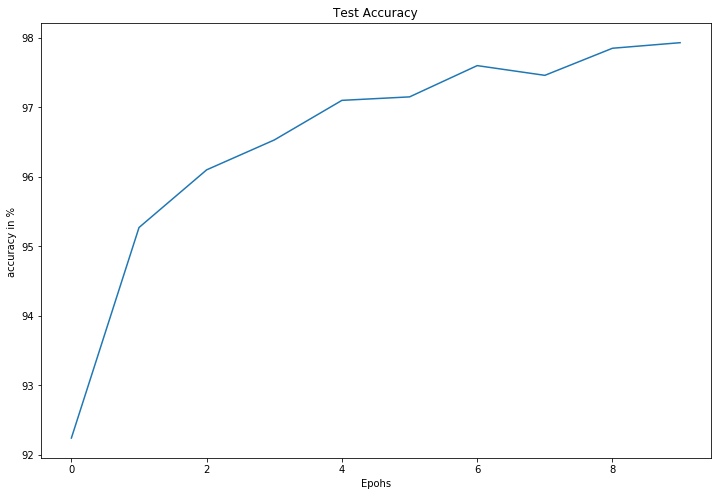

In [49]:
#plotting test accuracy


fig = plt.figure(figsize=(12, 8))
plt.plot([i for i in range(int(num_epochs))],testacc)
plt.title("Test Accuracy")
plt.xlabel("Epohs")
plt.ylabel("accuracy in % ")
plt.show()

label:  5
model prediction:  5


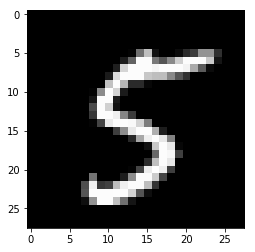

In [50]:
# check 130th sample of test
plt.imshow(mnist_testset[129][0].reshape(28,28).numpy(),cmap='gray')
print('label: ', mnist_testset[129][1])
print('model prediction: ', np.array(pred_classes.cpu())[129])